## Objectives

1. Research function is interested in how the market is evolving and are asking for a data visualization dashboard that they can use to analyze the market. Please propose and prepare a set of visualizations using any python visualization and your commentary. (THIS FILE)

2. Now that you know more about the data, a trader is asking you to come up with one or multiple forecasting model(s) for the coffee prices. After the implementation, we assume that you will present the model(s) to the trader who does not know about data science, but who is paying a lot of attention to the results and their interpretation. (OTHER FILE)

# Data Wrangling and Exploratory Data Analysis

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import sqlite3

#### Load Data

In [2]:
conn = sqlite3.connect('coffee.db')

query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""

cursor = conn.cursor()

cursor.execute(query)

print(cursor.fetchall())


df = pd.read_sql_query(query, conn)


[('market',), ('price',), ('SND',), ('coffee_type',)]


Listed above are the table names in our database. We can convert these all to dataframes through our queries.

In [3]:
queryMarket = 'SELECT * FROM market'
queryPrice = 'SELECT * FROM price'
querySND = 'SELECT * FROM SND'
queryCoffeeType = 'SELECT * FROM coffee_type'

dfMarket = pd.read_sql_query(queryMarket, conn)
dfPrice = pd.read_sql_query(queryPrice, conn)
dfSND = pd.read_sql_query(querySND, conn)
dfCoffeeType = pd.read_sql_query(queryCoffeeType, conn)

In [4]:
print(dfMarket.head())
print(dfPrice.head())
print(dfSND.head())
print(dfCoffeeType.head())

         date actvsproj         DXY  USDBRL
0  2001-12-31       act  116.750000   2.311
1  2002-01-31       act  120.239998   2.413
2  2002-02-28       act  119.160004   2.365
3  2002-03-31       act  118.620003   2.325
4  2002-04-30       act  115.190002   2.361
         date  coffee_type_id actvsproj  price
0  2001-12-31               1       act  48.15
1  2002-01-31               1       act  47.65
2  2002-02-28               1       act  46.30
3  2002-03-31               1       act  59.20
4  2002-04-30               1       act  52.85
         date  coffee_type_id  certified_stock  total_consumption  \
0  2001-12-31               1      1114.557832        4792.057525   
1  2002-01-31               1      1087.076160        4861.908518   
2  2002-02-28               1      1026.468713        4349.975139   
3  2002-03-31               1       961.625592        4647.049927   
4  2002-04-30               1       892.695043        4755.849295   

   total_stock  total_supply  total_dem

Let's check out our column types

In [5]:
dfMarket.dtypes

date          object
actvsproj     object
DXY          float64
USDBRL       float64
dtype: object

We need to convert our date columns to datetime

In [6]:
dfMarket['date'] = pd.to_datetime(dfMarket['date'])
dfPrice['date'] = pd.to_datetime(dfPrice['date'])
dfSND['date'] = pd.to_datetime(dfSND['date'])

In [7]:
dfMarket.dtypes

date         datetime64[ns]
actvsproj            object
DXY                 float64
USDBRL              float64
dtype: object

Let's quickly make sure our data has no null values

In [8]:
print(dfMarket[dfMarket.isna().any(axis=1)])
print(dfPrice[dfPrice.isna().any(axis=1)])
print(dfSND[dfSND.isna().any(axis=1)])

Empty DataFrame
Columns: [date, actvsproj, DXY, USDBRL]
Index: []
Empty DataFrame
Columns: [date, coffee_type_id, actvsproj, price]
Index: []
Empty DataFrame
Columns: [date, coffee_type_id, certified_stock, total_consumption, total_stock, total_supply, total_demand]
Index: []


Plotting basic graphs of each table and look for trends

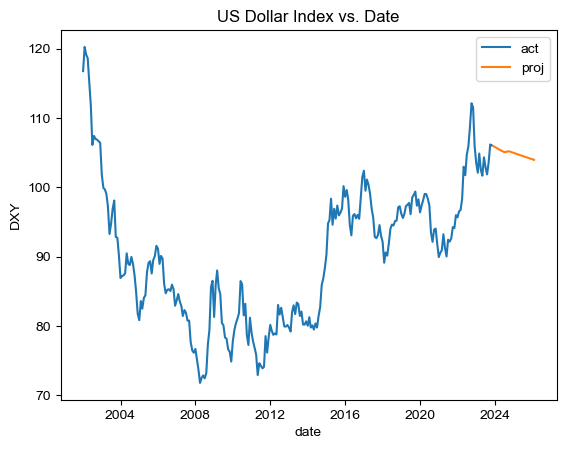

In [9]:
sns.lineplot(dfMarket,x='date',y='DXY',hue='actvsproj')
plt.legend()
plt.title('US Dollar Index vs. Date')
sns.set_style("darkgrid")
plt.show()

This graph shows our US Dollar Index versus Date. In the future, we can look at how the price might affect our product's prices.

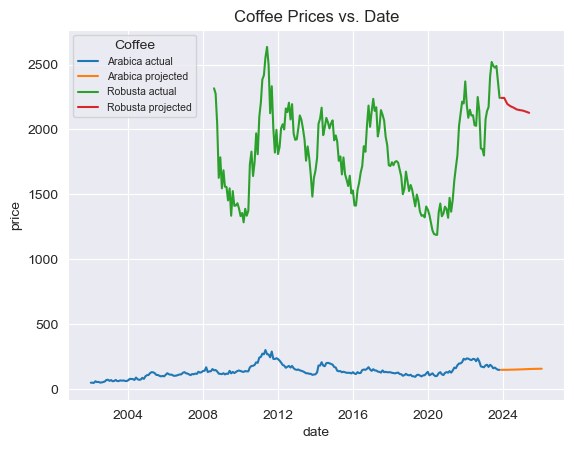

In [10]:
act1 = dfPrice[(dfPrice['coffee_type_id'] == 1) & (dfPrice['actvsproj'] == 'act')]
proj1 = dfPrice[(dfPrice['coffee_type_id'] == 1) & (dfPrice['actvsproj'] == 'proj')]
act2 = dfPrice[(dfPrice['coffee_type_id'] == 2) & (dfPrice['actvsproj'] == 'act')]
proj2 = dfPrice[(dfPrice['coffee_type_id'] == 2) & (dfPrice['actvsproj'] == 'proj')]
sns.lineplot(act1,x='date',y='price',label='Arabica actual')
sns.lineplot(proj1,x='date',y='price',label='Arabica projected')
sns.lineplot(act2,x='date',y='price',label='Robusta actual')
sns.lineplot(proj2,x='date',y='price',label='Robusta projected')
plt.legend(title='Coffee', fontsize = '7.5')
plt.title('Coffee Prices vs. Date')
plt.show()

Let's see if we can try see any possible correlation between the two coffee products on similar dates by looking at their returns between dates.

Correlation of Arabica and Robusta on similar dates:  0.6494522144774083


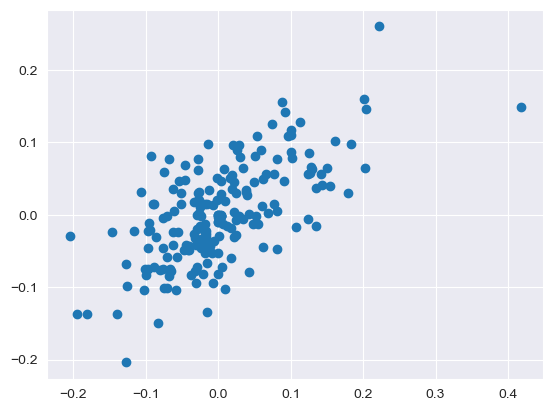

In [11]:
dfArabica = dfPrice[dfPrice['coffee_type_id'] == 1]
dfRobusta = dfPrice[dfPrice['coffee_type_id'] == 2]
dfPriceMixed = pd.merge(dfArabica, dfRobusta, on='date', how='inner')
dfPriceMixed.set_index('date', inplace=True)

returns = dfPriceMixed[['price_x','price_y']].pct_change()
correlation = returns['price_x'].corr(returns['price_y'])
print("Correlation of Arabica and Robusta on similar dates: ", correlation)

plt.scatter(returns['price_x'], returns['price_y'])
plt.show()

From this correlation, we can see a somewhat strong correlation in prices between the two products so that when one goes up, the other one will also slightly go up as well as compared to being competitiors on the market. The next step would be to look at the supply and demand charts.

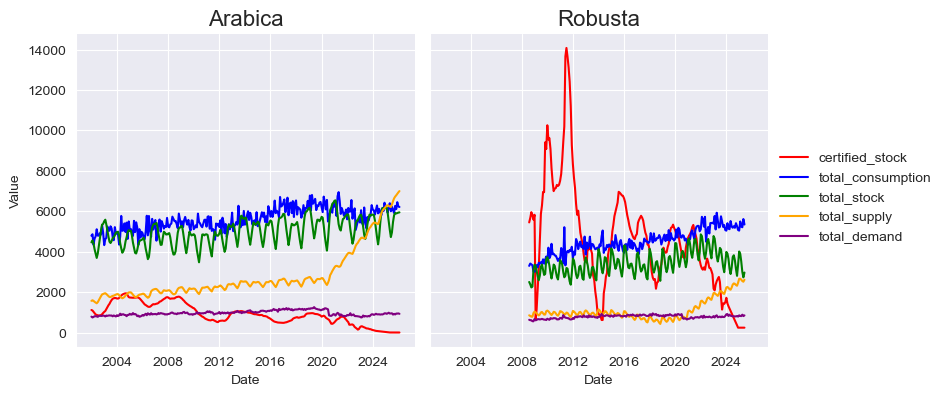

In [12]:
dfSNDGraph = dfSND.merge(dfCoffeeType, on='coffee_type_id', how='left')

g = sns.FacetGrid(dfSNDGraph, col="coffee_type",height=4)

g.map(sns.lineplot, 'date', 'certified_stock', label='certified_stock', color='r')
g.map(sns.lineplot, 'date', 'total_consumption', label='total_consumption', color='b')
g.map(sns.lineplot, 'date', 'total_stock', label='total_stock', color='g')
g.map(sns.lineplot, 'date', 'total_supply', label='total_supply', color='orange')
g.map(sns.lineplot, 'date', 'total_demand', label='total_demand', color='purple')

g.add_legend()
g.set_axis_labels("Date", "Value")
g.set_titles(col_template="{col_name}", size=16)
plt.show()

We can now look at potential correlations between our 5 different values

In [13]:
dfSNDArabica = dfSND[dfSND['coffee_type_id'] == 1]
dfSNDRobusta = dfSND[dfSND['coffee_type_id'] == 2]
dfSNDMixed = pd.merge(dfSNDArabica, dfSNDRobusta, on='date', how='inner')

Correlation of Arabica and Robusta on certified stock:  0.010630260065934776
Correlation of Arabica and Robusta on total consumption:  0.2808143757395635
Correlation of Arabica and Robusta on total supply:  0.23032998152522816
Correlation of Arabica and Robusta on total stock:  0.25434239315769175
Correlation of Arabica and Robusta on total demand:  0.5182687137914403


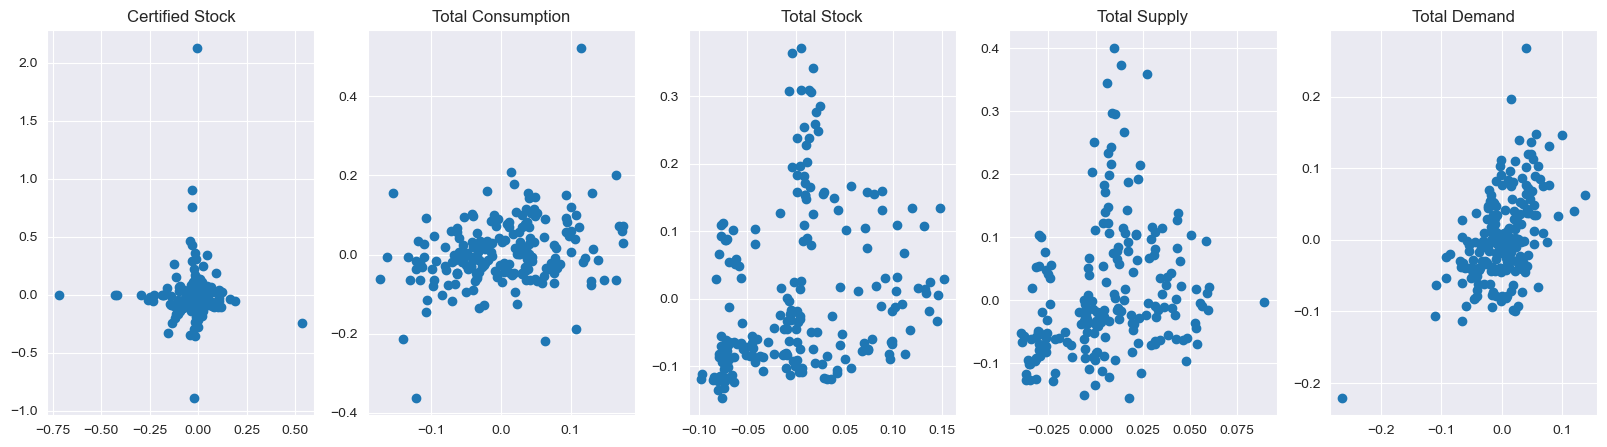

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

returns = dfSNDMixed[['certified_stock_x', 'certified_stock_y']].pct_change()
correlation = returns['certified_stock_x'].corr(returns['certified_stock_y'])
print("Correlation of Arabica and Robusta on certified stock: ", correlation)
ax[0].scatter(returns['certified_stock_x'], returns['certified_stock_y'])
ax[0].set_title('Certified Stock')

returns = dfSNDMixed[['total_consumption_x', 'total_consumption_y']].pct_change()
correlation = returns['total_consumption_x'].corr(returns['total_consumption_y'])
print("Correlation of Arabica and Robusta on total consumption: ", correlation)
ax[1].scatter(returns['total_consumption_x'], returns['total_consumption_y'])
ax[1].set_title('Total Consumption')

returns = dfSNDMixed[['total_stock_x', 'total_stock_y']].pct_change()
correlation = returns['total_stock_x'].corr(returns['total_stock_y'])
print("Correlation of Arabica and Robusta on total supply: ", correlation)
ax[2].scatter(returns['total_stock_x'], returns['total_stock_y'])
ax[2].set_title('Total Stock')

returns = dfSNDMixed[['total_supply_x', 'total_supply_y']].pct_change()
correlation = returns['total_supply_x'].corr(returns['total_supply_y'])
print("Correlation of Arabica and Robusta on total stock: ", correlation)
ax[3].scatter(returns['total_supply_x'], returns['total_supply_y'])
ax[3].set_title('Total Supply')

returns = dfSNDMixed[['total_demand_x', 'total_demand_y']].pct_change()
correlation = returns['total_demand_x'].corr(returns['total_demand_y'])
print("Correlation of Arabica and Robusta on total demand: ", correlation)
ax[4].scatter(returns['total_demand_x'], returns['total_demand_y'])
ax[4].set_title('Total Demand')

plt.show()

While the first four graphs do not show a strong correlation, we can see a slight moderate correlation with total demand of the two products similar to the price comparsion we had before.

We can now look at the comparison of the price vs. these features. We'll do this by making a heatmap for each product.

In [15]:
# USE SQL Query to generate DataFrame
queryArabica = 'SELECT p.date, p.actvsproj, p.price, s.certified_stock, s.total_consumption, s.total_stock, s.total_supply, s.total_demand FROM price AS p JOIN SND AS s ON p.date = s.date WHERE p.coffee_type_id = 1'
queryRobusta = 'SELECT p.date, p.actvsproj, p.price, s.certified_stock, s.total_consumption, s.total_stock, s.total_supply, s.total_demand FROM price AS p JOIN SND AS s ON p.date = s.date WHERE p.coffee_type_id = 2'

dfArabica = pd.read_sql_query(queryArabica, conn)
dfRobusta = pd.read_sql_query(queryRobusta, conn)

dfArabica.set_index('date', inplace=True)
dfArabicaCorr = dfArabica.drop('actvsproj', axis=1)
dfArabicaCorr = dfArabicaCorr.pct_change().iloc[1:,:]

dfRobusta.set_index('date', inplace=True)
dfRobustaCorr = dfRobusta.drop('actvsproj', axis=1)
dfRobustaCorr = dfRobustaCorr.pct_change().iloc[1:,:]

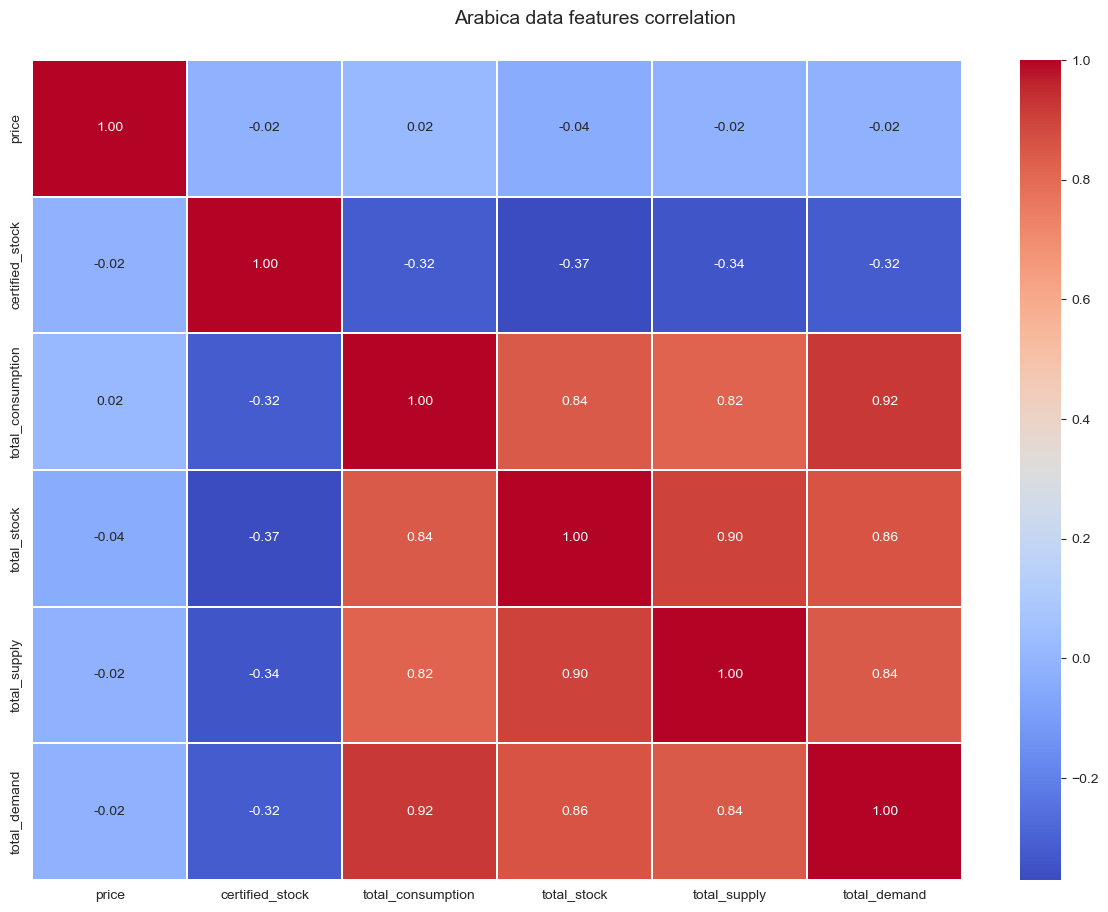

In [16]:
# Generate heat map
corrmat = dfArabicaCorr.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 10))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Arabica data features correlation', fontsize=14)

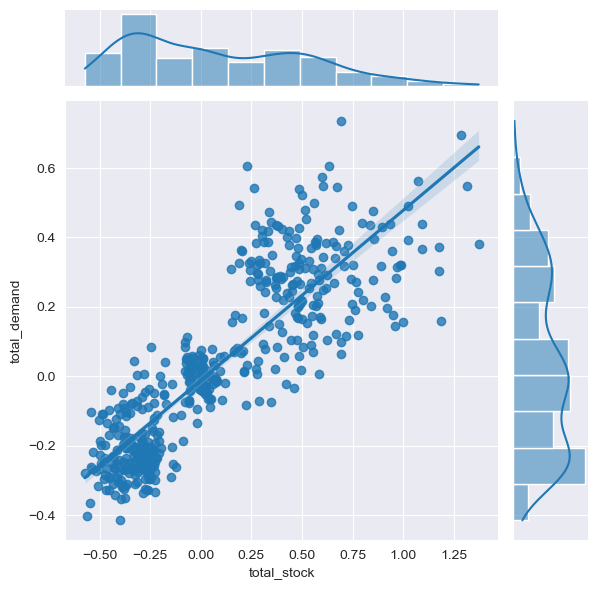

In [17]:
sns.jointplot(x='total_stock', y='total_demand', data=dfArabicaCorr, kind="reg")

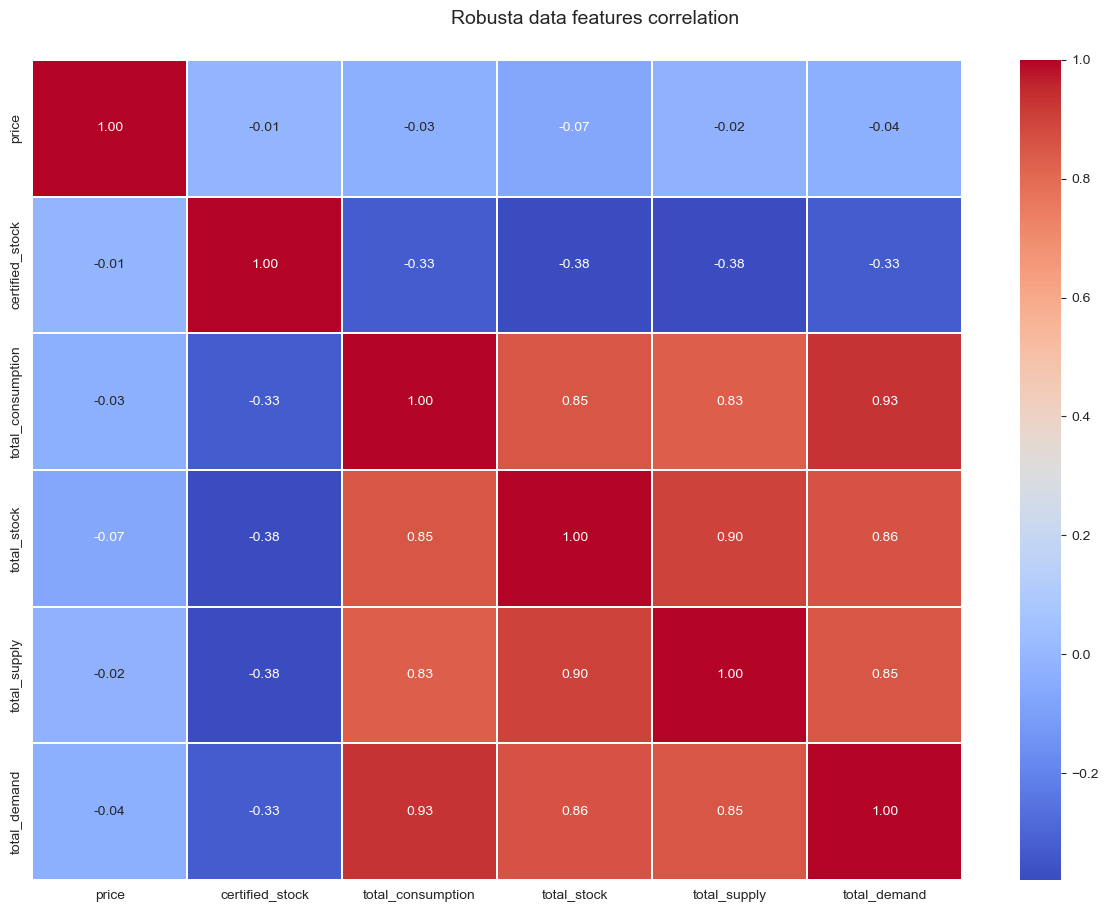

In [18]:
corrmat = dfRobustaCorr.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 10))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Robusta data features correlation', fontsize=14)

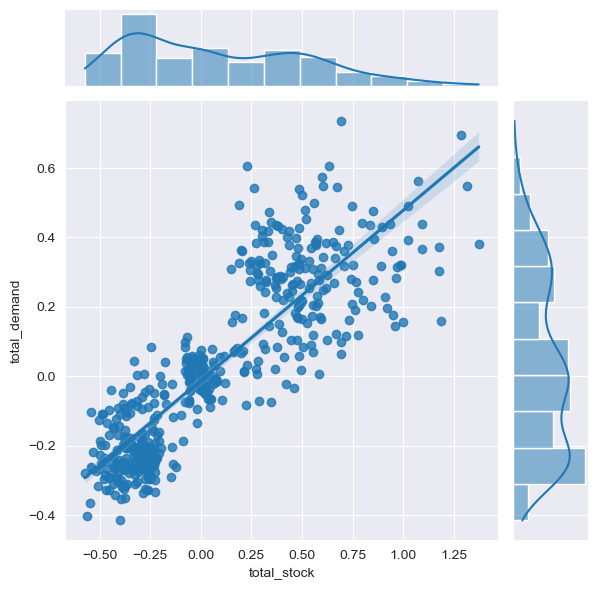

In [19]:
sns.jointplot(x='total_stock', y='total_demand', data=dfArabicaCorr, kind="reg")

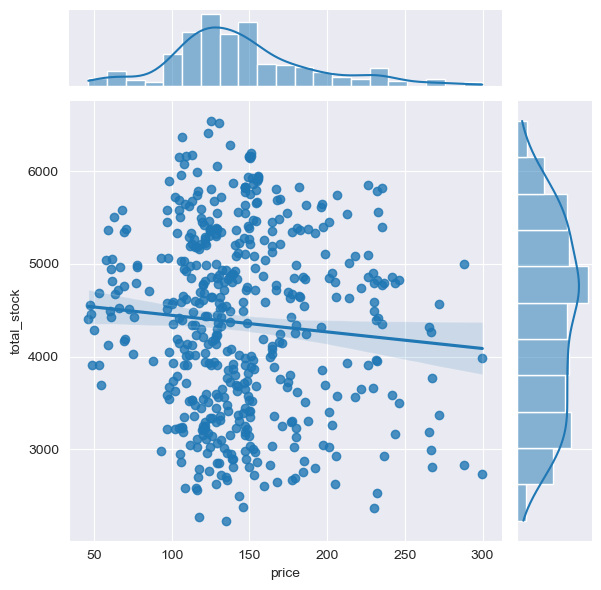

In [20]:
sns.jointplot(x='price', y='total_stock', data=dfArabica, kind="reg");

Notice that the supply has a high positive correlation with the demand but not the price which seems to show no correlation at all. This may be beneficial in researching this area in order to make a potential price increase in our products without taking a decrease in sales.

We can look into these features for our next step, preprocessing and modeing.

# Preprocessing and Modeling

Let's first begin by trying to figure out if any patterns exist between our price models for each product by using the Augmented Dickey-Fuller test in order to test for a random walk.

In [21]:
# sort dataframe by product and get their price column only, also remove the proj
ArabicaPrice = dfPrice[(dfPrice['coffee_type_id'] == 1) & (dfPrice['actvsproj'] == 'act')]
RobustaPrice = dfPrice[(dfPrice['coffee_type_id'] == 2) & (dfPrice['actvsproj'] == 'act')]

ArabicaPriceProj = dfPrice[(dfPrice['coffee_type_id'] == 1) & (dfPrice['actvsproj'] == 'proj')]
RobustaPriceProj = dfPrice[(dfPrice['coffee_type_id'] == 2) & (dfPrice['actvsproj'] == 'proj')]

ArabicaPrice = ArabicaPrice[['date','price']]
ArabicaPrice.set_index('date', inplace=True)
RobustaPrice = RobustaPrice[['date','price']]
RobustaPrice.set_index('date', inplace=True)

ArabicaPriceProj = ArabicaPriceProj[['date','price']]
ArabicaPriceProj.set_index('date', inplace=True)
RobustaPriceProj = RobustaPriceProj[['date','price']]
RobustaPriceProj.set_index('date', inplace=True)

In [22]:
from statsmodels.tsa.stattools import adfuller

ArabicaResults = adfuller(ArabicaPrice)
RobustaResults = adfuller(RobustaPrice)

print('The p-value of the test on Arabica is: ' + str(ArabicaResults[1]))
print('The p-value of the test on Robusta is: ' + str(RobustaResults[1]))

The p-value of the test on Arabica is: 0.055678802604660835
The p-value of the test on Robusta is: 0.0522341876737635


Because of our low p-value based on our Augmented Dickey-Fuller test, we can say that we are not experienceing a random walk within our prices and therfore are seeing some sort of correlation over time. Because of this, we have stationary graphs which will be much easier to model with next.

We can calculate the autoregressive (AR) model for each product in order to see where they might predict our price of our product is going.

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


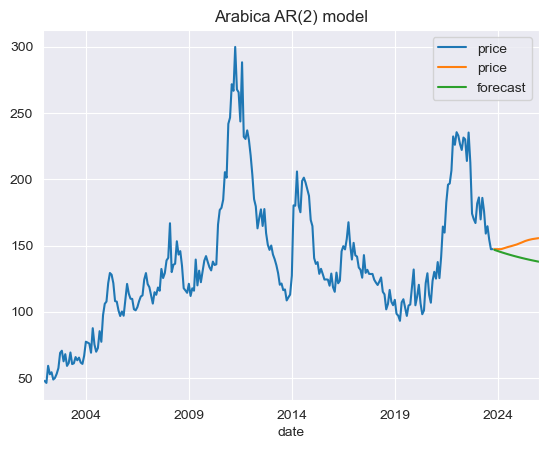

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

mod = ARIMA(ArabicaPrice, order=(2,0,0))
res = mod.fit()

fig, ax = plt.subplots()
ArabicaPrice.plot(ax=ax)
ArabicaPriceProj.plot(ax=ax)
plot_predict(res, start='2023-11-30	', end='2026-01-31	', ax=ax, alpha=None)
plt.title('Arabica AR(2) model')
plt.show()

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


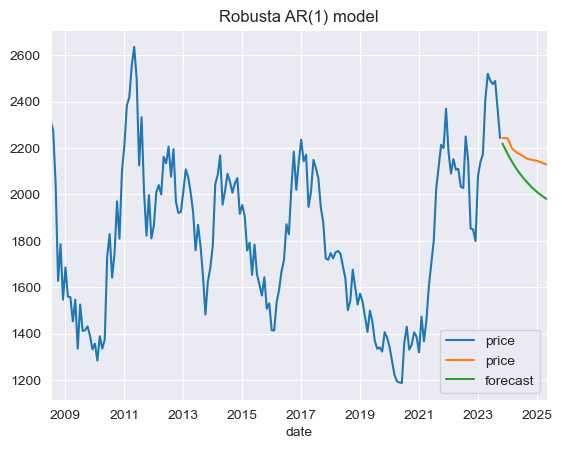

In [24]:
mod = ARIMA(RobustaPrice, order=(1,0,0))
res = mod.fit()

fig, ax = plt.subplots()
RobustaPrice.plot(ax=ax)
RobustaPriceProj.plot(ax=ax)
plot_predict(res, start='2023-11-30	', end='2025-05-31	', ax=ax, alpha=None)
plt.title('Robusta AR(1) model')
plt.show()

Looking at our models, we can see that our Arabrica price projections might be off because modeling suggests that the price will drop in the future and not raise. As for Robusta, we can see that we may have underestimated how much the price may go down in the future. However, this model is only one example as another may show a similar or different outcome. With more data and modeling, we may be able to better accurately predict where the prices of our products are heading in the future.

In [25]:
# CLOSE SQL CONNECTION
conn.close()